# Generate a PSF for SIXTE
In this notebook, I'll take a SIXTE PSF file from Thomas Dauser and modify it. My goal is to make the PSF look good, not to provide a physics-based simulation. At this point, we simply do not know enough about the mirrors to reliably predict the shape of the scattering wings and their energy dependence. Instead, this PSF should be seen as a "requirement" in the sense of "We want a PSF that looks like this or better". So, these PSFs are build up using some physics intuition and can be used to simulate AXIS observations that look realistic, without necessarily being correct in all aspects.

However, a realistically-looking PSF will be sufficient to analyze potential science cases; no science case depends on e.g. the exact energy dependence on the scattering wings.

Here, I chose to describe the PSF as a Voigt profile. This functional form has the Gaussian core we expect, but also wide wings that we see in all X-ray telescopes to date, e.g. Chandra. I select the parameters to be qualitatively similar to the Chandra PSF, but again, **the AXIS PSF will almost certainly not look exactly as described here.**, Still, **the PSF generated here is more realistic than simply picking a Gaussian**.



In [45]:
import os
import re
import numpy as np
from scipy.special import voigt_profile
from astropy.table import Table
from astropy.io import fits
import datetime
import matplotlib.pyplot as plt

In [2]:
import urllib.request

In [3]:
# See later if I even need this file or make the new files form scratch, once I know how everything is called.

# Download the file from `url` and save it locally under `file_name`:
if not os.path.exists('axis_psf_gauss_v2.fits'):
    urllib.request.urlretrieve('http://www.sternwarte.uni-erlangen.de/~dauser/axis/psf/axis_psf_gauss_v2.fits',
                           'axis_psf_gauss_v2.fits')

In [5]:
hdus = fits.open('axis_psf_gauss_v2.fits')

In [8]:
# What is the units of that?
CDELT = 1.6E-06  # in degrees/pixel

# Empirically determined to match Thomas Dauser's files. 
# Does to seem to make any sense with the CDELT numbers.
pixel_per_arcsec = 12.5

# Size of the images we want to generate. Match Thomas Dauser's file here
# so that I can just replace the data of the HDUs and don't have to update
# the headers.
n_pix = 250


In [9]:
def image_voigt(n_pix, FWHM, gamma):
    sigma = FWHM / 2.355
    # +0.5 to get to the center of a pixel and because FITS has origin at [1, 1], while numpy has at [0, 0]
    voigt = voigt_profile(np.arange(n_pix) - n_pix / 2. + 0.5, 
                          sigma * pixel_per_arcsec, 
                          gamma * pixel_per_arcsec)
    arr = voigt[None, :] * voigt[:, None]
    arr = arr / arr.sum()
    return arr

In [10]:
arr = image_voigt(n_pix, 1., 0.001)

Text(0.5, 1.0, 'Compare Thomas Dauser PSF with mine to check format')

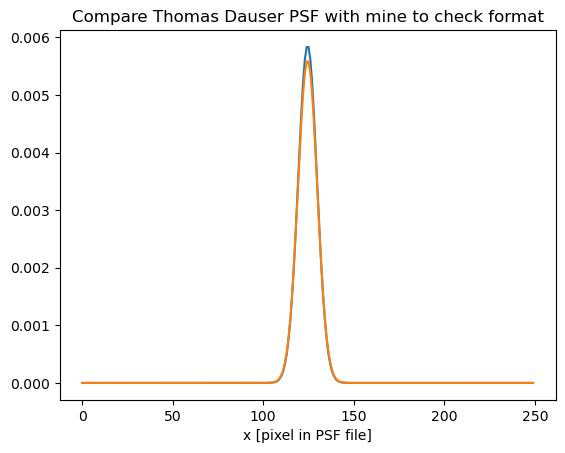

In [11]:
plt.plot(hdus[0].data[125, :])
plt.plot(arr[125, :])
plt.xlabel('x [pixel in PSF file]')
plt.title('Compare Thomas Dauser PSF with mine to check format')


The plot above shows a cut through the simulated PSF. Blue is the file from Thomas Dauser, orange is mine. For very small values of Gamma my Voigt profile is very similar to a Gaussian and the FWHM matches. Note that the orange line is a little lower because it's normalized over 250*250 pix in the image, while the other file uses only a sub-set and sets the outer pats identical to 0.

In [30]:
tab = '''
#Photon Energy (keV)	Off-Axis Angle (arcmin)								
energies	0	2	4	6	8	10	12	14	16
0.2	1.00	1.00	1.01	1.02	1.06	1.14	1.46348	1.86108	2.48588
0.5	1.00	1.00	1.01	1.02	1.07	1.16	1.24003	1.44851	1.76552
2.0	1.00	1.00	1.01	1.04	1.09	1.21	1.3998	1.7968	2.4674
4.0	1.00	1.00	1.01	1.05	1.16	1.33	1.52896	1.76496	1.98176
6.0	1.00	1.00	1.02	1.08	1.22	1.46	1.834	2.3678	3.0912
8.0	1.00	1.00	1.02	1.10	1.28	1.59	2.05264	2.71584	3.59264
10.0	1.00	1.00	1.03	1.13	1.34	1.70	2.2	2.9488	3.9568
12.0	1.00	1.00	1.03	1.16	1.41	1.84	2.54584	3.47604	4.69824
15.0	1.00	1.00	1.04	1.19	1.49	2.00	2.85184	3.97024	5.44544
'''


In [31]:
# Table from Thomas Dauser in slack
# Supposed to show how PSF width increases with energy and off-axis angle
# Origin not known to me, but makes sense.
# Entries are (hopefully) FWHM in arcsec
FWHMtab = Table.read(tab, format='ascii', header_start=0, data_start=1, delimiter='\t')

In [17]:
def image_to_EE(image, rarray):
    '''Implementatin cna be done a lot better using numpy array indices more
    but is fast enough for now, so don't bother to optimize.
    '''
    nx, ny = image.shape
    dx, dy = np.mgrid[0: nx, 0: ny]
    dx = dx - nx / 2. + 0.5
    dy = dy - ny / 2. + 0.5
    radius = np.sqrt(dx**2 + dy**2)
    return np.array([image[radius <= r].sum() for r in rarray])
    

In [18]:
rarray = np.arange(0, 52.5)

Text(0.5, 0, 'radius [arcsec]')

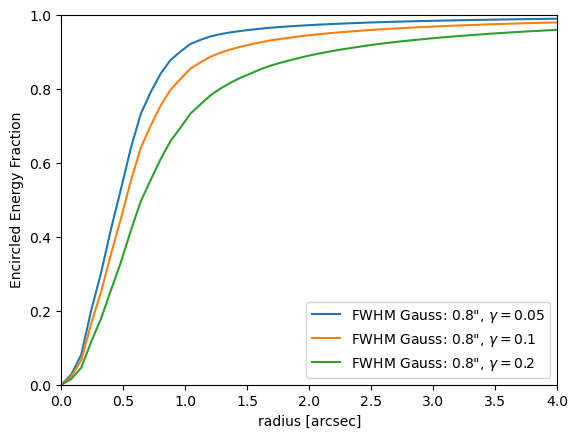

In [19]:
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, .8, .05), rarray),
         label='FWHM Gauss: 0.8", $\gamma=0.05$')
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, .8, .1), rarray),
         label='FWHM Gauss: 0.8", $\gamma=0.1$')
plt.plot(rarray / pixel_per_arcsec, image_to_EE(image_voigt(250, .8, .2), rarray),
         label='FWHM Gauss: 0.8", $\gamma=0.2$')
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.legend()
plt.ylabel('Encircled Energy Fraction')
plt.xlabel('radius [arcsec]')

Compare this plot to the Chandra PSF [in Fig 4.6 in the proposer's observatory guide](https://cxc.harvard.edu/proposer/POG/html/chap4.html#tth_sEc4.2.3). I have manually tuned the parameters to get qualitative agreement with the Chandra PSF. In Chandra, the on-axis PSF is $< 0.5"$, while we aim for 1" in AXIS. The figure above is scaled to have the x-axis run from 0 to 4.0, while the figure in the Chandra POG runs from 0 to 2.0". So, the PSFs should look similar if putting the figures on top of each other. 

Howe do the scattering wings scale if the PSF increases? Well, we don't know exactly, so I've chosen wings that are a little wider than Chandra, just as the core is a little wider, but not twice as much. For example, the orange line hits 95% EE at 2 arcsec, similar to the 1.5 keV line in the Chandra POG. That's probably an optimistic assumption, but hopefully good enough for now.

So, I'll generate PSF files with the wings using $\gamma=0.05$ for low energies, $\gamma=0.1$ around 1.5 keV and $\gamma=0.2$ at higher energies. For the Gaussian core of the PSF, I use the 0.8 times the FWHM form the energy and off-axis angle dependent table that Thomas gave me (not sure where that comes from). I make the narrower, since the wings contribute to the FWHM, so that the resulting total FWHM gives a similar FWHM, just with larger wings.

Again, this is no more than an educated guess, and we should not rely on the exact numbers I've chosen here.

In [38]:
gamma = {0.2: 0.05, # blue line above
         0.5:0.075, 
         2.0:0.1, # orange line above
         4.0: 0.15, 
         6.0: 0.2, 8.0:0.2, 10.:0.2, 12.:0.2, 15.:0.2,  # green line above
         }

In [35]:
FWHMtab

energies,0,2,4,6,8,10,12,14,16
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.2,1.0,1.0,1.01,1.02,1.06,1.14,1.46348,1.86108,2.48588
0.5,1.0,1.0,1.01,1.02,1.07,1.16,1.24003,1.44851,1.76552
2.0,1.0,1.0,1.01,1.04,1.09,1.21,1.3998,1.7968,2.4674
4.0,1.0,1.0,1.01,1.05,1.16,1.33,1.52896,1.76496,1.98176
6.0,1.0,1.0,1.02,1.08,1.22,1.46,1.834,2.3678,3.0912
8.0,1.0,1.0,1.02,1.1,1.28,1.59,2.05264,2.71584,3.59264
10.0,1.0,1.0,1.03,1.13,1.34,1.7,2.2,2.9488,3.9568
12.0,1.0,1.0,1.03,1.16,1.41,1.84,2.54584,3.47604,4.69824
15.0,1.0,1.0,1.04,1.19,1.49,2.0,2.85184,3.97024,5.44544


In [57]:
def PSF_voigt(n_pix, energy, offaxis, FWHMscale=1):
    '''Currently, only to for energies that match table exactly.
    Could interpolate etc, but SIXTE does that already internally, so 
    no need to do that here.
    '''
    FWHM = np.interp(0.2, FWHMtab['energies'], FWHMtab[str(int(offaxis))])
    FWHM *= FWHMscale
    return image_voigt(n_pix, FWHM, gamma[energy])

In [ ]:
extnamepattern = re.compile("(?P<energy>[0-9.]+)keV_(?P<offaxis>[0-9.]+)amin")

In [71]:
def make_psf_file(filename, FWHMscale=1):
    hdus = fits.open('axis_psf_gauss_v2.fits')
    for hdu in hdus:
        out = extnamepattern.search(hdu.header['EXTNAME'])
        hdu.data = PSF_voigt(hdu.header['NAXIS1'], 
                             float(out.group('energy')),
                             float(out.group('offaxis')),
                             FWHMscale=FWHMscale)
        hdu.header['HISTORY'] = 'modified by Moritz Guenther'
        hdu.header['HISTORY'] = 'to change the functional shape of the PSF'
        hdu.header['HISTORY'] = 'to include scattering wings'
        hdu.header['HISTORY'] = f'Version: {datetime.datetime.now()}'
        hdu.header['HISTORY'] = f'FWHMscale: {FWHMscale}'
    hdus.writeto(filename, overwrite=True)

I'm making two PSFs: One based on an "about 1 arcsec" PSF and a second one for "about 2 arcsec". I'm assuming that the PSF degrades from one file to the other, because the alignment of the mirror shells is not as good, but the roughness and figure errors (which cause the wings) stay the same, thus, I'm only scaling up the central Gaussian, not the wings.
Since the total PSF is Gaussian core AND wings I need to scale the core by a factor that's a little more than 2 to make the combined width about twice as big. I'm using a factor of 2.2, but really that's just drawn out of a hat; again, the goal is not to get all details right (that's impossible at this point) but more to generate PSFs that will make images with the right properties.

In [72]:
make_psf_file('axis_psf_voigt_1arcsec.fits', FWHMscale=1)
make_psf_file('axis_psf_voigt_2arcsec.fits', FWHMscale=2.2)